In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART

### Part 1: Classification trees

In [7]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8, "Yes", "No")
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [8]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [11]:
clf = DTC(criterion='entropy', max_depth=3, random_state=0)
clf.fit(X, High)
print(f'Accuracy score: {accuracy_score(High, clf.predict(X))}')
print(f'Log loss: {np.sum(log_loss(High, clf.predict_proba(X)))}')

Accuracy score: 0.79
Log loss: 0.4710647062649358


[Text(0.5, 0.875, 'ShelveLoc[Good] <= 0.5\nentropy = 0.977\nsamples = 400\nvalue = [236, 164]'),
 Text(0.25, 0.625, 'Price <= 92.5\nentropy = 0.894\nsamples = 315\nvalue = [217, 98]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Income <= 57.0\nentropy = 0.887\nsamples = 46\nvalue = [14, 32]'),
 Text(0.0625, 0.125, 'entropy = 0.881\nsamples = 10\nvalue = [7, 3]'),
 Text(0.1875, 0.125, 'entropy = 0.711\nsamples = 36\nvalue = [7, 29]'),
 Text(0.375, 0.375, 'Advertising <= 13.5\nentropy = 0.804\nsamples = 269\nvalue = [203, 66]'),
 Text(0.3125, 0.125, 'entropy = 0.687\nsamples = 224\nvalue = [183, 41]'),
 Text(0.4375, 0.125, 'entropy = 0.991\nsamples = 45\nvalue = [20, 25]'),
 Text(0.75, 0.625, 'Price <= 135.0\nentropy = 0.767\nsamples = 85\nvalue = [19, 66]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'US[Yes] <= 0.5\nentropy = 0.523\nsamples = 68\nvalue = [8, 60]'),
 Text(0.5625, 0.125, 'entropy = 0.937\nsamples = 17\nvalue = [6, 11]'),
 Text(0.6875, 0.125, 'entropy = 0.

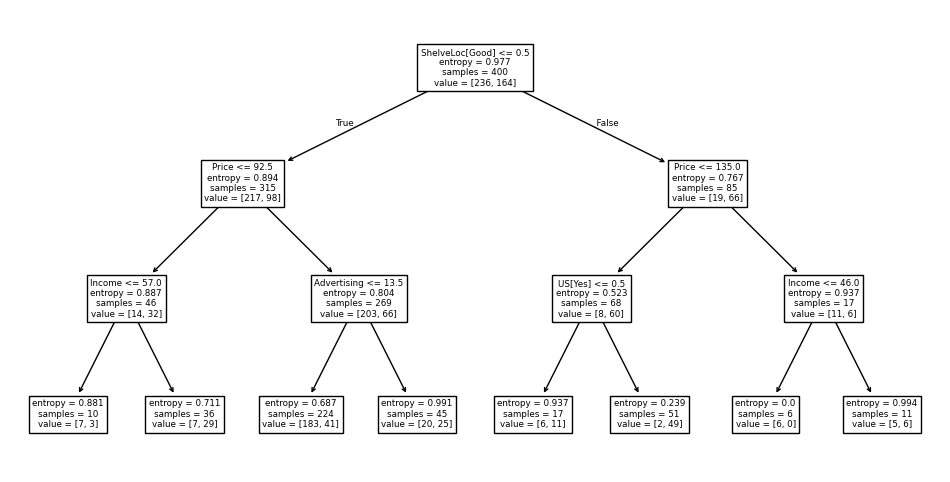

In [13]:
ax = subplots(figsize=(12, 6))[1]
plot_tree(clf, feature_names=feature_names, ax=ax)

In [14]:
print(export_text(clf, feature_names=feature_names, show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In [15]:
validation = skm.ShuffleSplit(n_splits=1, test_size=200, random_state=0)
results = skm.cross_validate(clf, D, High, cv=validation)
results['test_score']

array([0.685])

In [17]:
X_train, X_test, High_train, High_test = skm.train_test_split(X, High, test_size=0.5, random_state=0)
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

In [19]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10, random_state=1, shuffle=True)

grid = skm.GridSearchCV(clf, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

0.685

In [ ]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_, feature_names=feature_names, ax=ax)

In [22]:
best_.tree_.n_leaves

30

In [23]:
print(accuracy_score(High_test, best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test), High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


### Part 2: Regression trees

In [3]:
Boston = load_data('Boston')
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

[Text(0.5, 0.875, 'rm <= 6.797\nsquared_error = 84.765\nsamples = 354\nvalue = 22.745'),
 Text(0.25, 0.625, 'lstat <= 14.405\nsquared_error = 35.011\nsamples = 284\nvalue = 19.614'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'dis <= 1.474\nsquared_error = 20.776\nsamples = 167\nvalue = 22.981'),
 Text(0.0625, 0.125, 'squared_error = 0.0\nsamples = 2\nvalue = 50.0'),
 Text(0.1875, 0.125, 'squared_error = 12.072\nsamples = 165\nvalue = 22.653'),
 Text(0.375, 0.375, 'crim <= 5.782\nsquared_error = 16.049\nsamples = 117\nvalue = 14.808'),
 Text(0.3125, 0.125, 'squared_error = 10.345\nsamples = 67\nvalue = 16.872'),
 Text(0.4375, 0.125, 'squared_error = 10.334\nsamples = 50\nvalue = 12.042'),
 Text(0.75, 0.625, 'rm <= 7.435\nsquared_error = 85.388\nsamples = 70\nvalue = 35.451'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'crim <= 7.393\nsquared_error = 44.147\nsamples = 47\nvalue = 30.921'),
 Text(0.5625, 0.125, 'squared_error = 19.597\nsamples = 43\nvalue = 32.465'),
 Text

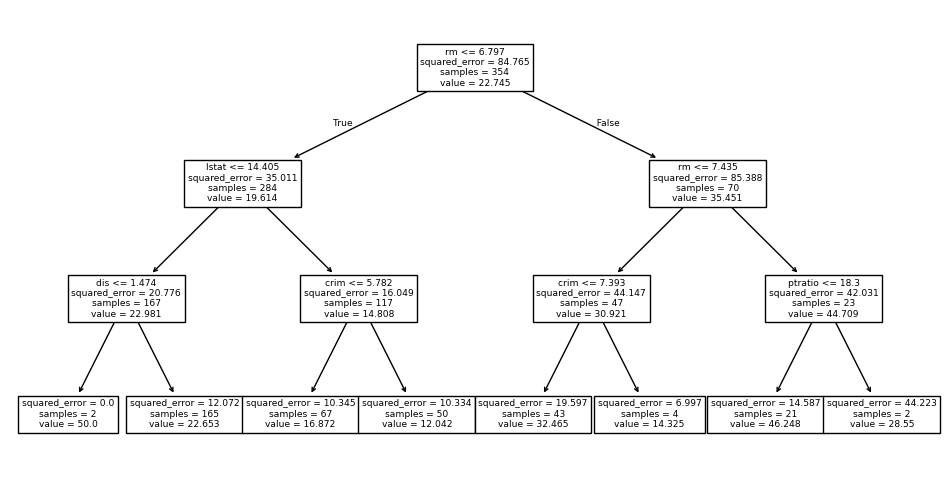

In [5]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, Boston['medv'], test_size=0.3, random_state=0)

reg = DTR(max_depth=3)
reg.fit(X_train, y_train)

ax = subplots(figsize=(12, 6))[1]
plot_tree(reg, feature_names=feature_names, ax=ax)

In [6]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(reg, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [8]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.06985754975404

[Text(0.5, 0.875, 'rm <= 6.797\nsquared_error = 84.765\nsamples = 354\nvalue = 22.745'),
 Text(0.25, 0.625, 'lstat <= 14.405\nsquared_error = 35.011\nsamples = 284\nvalue = 19.614'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'dis <= 1.474\nsquared_error = 20.776\nsamples = 167\nvalue = 22.981'),
 Text(0.0625, 0.125, 'squared_error = 0.0\nsamples = 2\nvalue = 50.0'),
 Text(0.1875, 0.125, 'squared_error = 12.072\nsamples = 165\nvalue = 22.653'),
 Text(0.375, 0.375, 'crim <= 5.782\nsquared_error = 16.049\nsamples = 117\nvalue = 14.808'),
 Text(0.3125, 0.125, 'squared_error = 10.345\nsamples = 67\nvalue = 16.872'),
 Text(0.4375, 0.125, 'squared_error = 10.334\nsamples = 50\nvalue = 12.042'),
 Text(0.75, 0.625, 'rm <= 7.435\nsquared_error = 85.388\nsamples = 70\nvalue = 35.451'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'crim <= 7.393\nsquared_error = 44.147\nsamples = 47\nvalue = 30.921'),
 Text(0.5625, 0.125, 'squared_error = 19.597\nsamples = 43\nvalue = 32.465'),
 Text

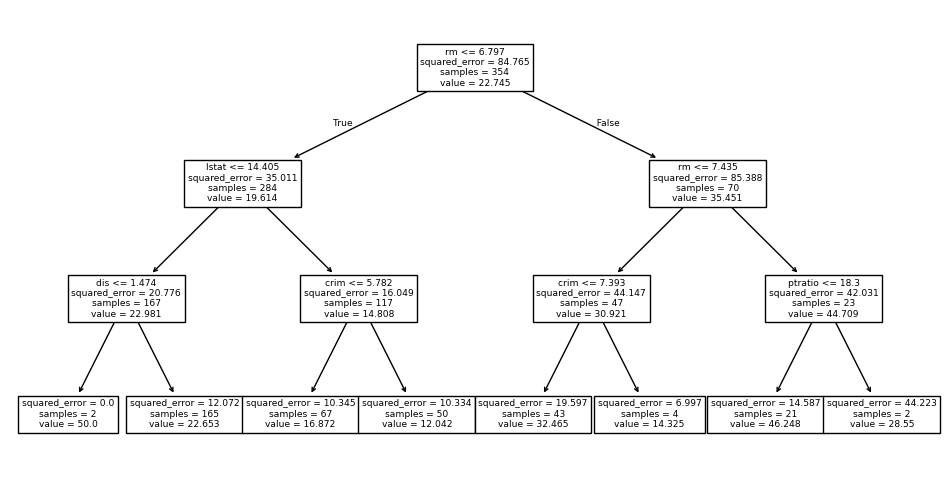

In [10]:
ax = subplots(figsize=(12, 6))[1]
plot_tree(G.best_estimator_, feature_names=feature_names, ax=ax)

### Part 3: Bagging and Random Forests

In [11]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

14.634700151315787

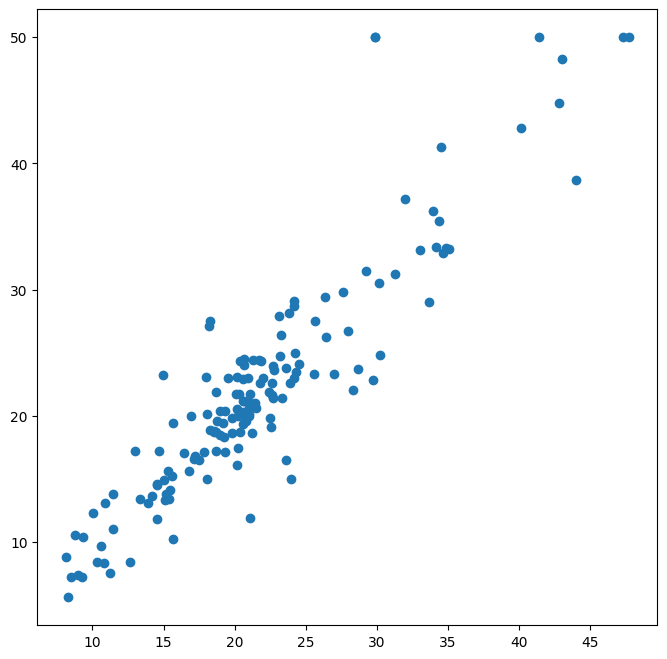

In [13]:
ax = subplots(figsize=(8, 8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [14]:
bag_boston = RF(max_features=X_train.shape[1], n_estimators=500, random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263161

In [15]:
RF_boston = RF(max_features=6, random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF) ** 2)

20.04276446710527

In [16]:
feature_imp = pd.DataFrame(
    {'importance': RF_boston.feature_importances_},
    index=feature_names
    )
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


### Part 4: Boosting

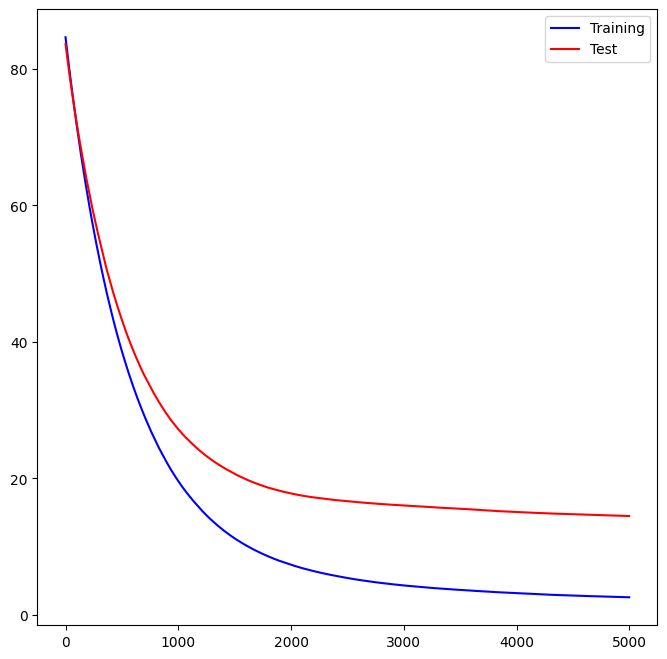

In [19]:
boost_boston = GBR(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=3,
    random_state=0
)
boost_boston.fit(X_train, y_train)

test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_) ** 2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8, 8))[1]
ax.plot(plot_idx, boost_boston.train_score_, 'b', label='Training')
ax.plot(plot_idx, test_error, 'r', label='Test')
ax.legend()

In [20]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test)
np.mean((y_test - y_hat_boost)**2)

14.501514553719565

### Part 5: Bayesian Additive Regression Trees

In [21]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [22]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

22.145009458109225

In [23]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0), index=D.columns)
var_inclusion

crim       26.933333
zn         27.866667
indus      26.466667
chas       22.466667
nox        26.600000
rm         29.800000
age        22.733333
dis        26.466667
rad        23.666667
tax        24.133333
ptratio    24.266667
lstat      31.000000
dtype: float64